In [18]:
import pandas as pd
import psycopg2
from psycopg2 import sql
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt

In [2]:
# Připojení k postgres

DB_USER = "postgres"
DB_PWD  = "VymrdanecLynux111"
DB_HOST = "localhost"
DB_PORT = 5432
DB_NAME = "postgres"

engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PWD}@{DB_HOST}:{DB_PORT}/{DB_NAME}",
    echo=False,          # True = vypíše SQL na stdout
    pool_pre_ping=True   # jistota, že se spojení obnoví, když „usne“
)

In [3]:
df_cizinci = pd.read_csv("cizinci_data.csv", sep=",", encoding="utf-8")
df_gdp = pd.read_csv("gdp_data.csv", sep=",", encoding="utf-8")
# kontrola
print(df_cizinci.head())
print(df_gdp.head())

  country gender       age  year
0     DZA    muž    <0; 5)  2023
1     AFG    muž  <35; 40)  2023
2     AUT    muž  <30; 35)  2023
3     BEL    muž    <0; 5)  2023
4     BEL    muž  <60; 65)  2023
  country  year          GDP
0     USA  2023  615 676 947
1     CHN  2023  395 222 131
2     DEU  2023  100 515 884
3     JPN  2023   93 381 830
4     IND  2023   79 235 323


In [ ]:
# Struktura tabulek
#
# CREATE TABLE years (
#     id SERIAL PRIMARY KEY,
#     year INT NOT NULL)
#
# CREATE TABLE gdp (
#     id SERIAL PRIMARY KEY,
#     year_id INT NOT NULL,
#     gdp NUMERIC NOT NULL,
#     country_id INT NOT NULL,
#     FOREIGN KEY (year_id) REFERENCES years(id))
#     FOREGIN KEY (country_id) REFERENCES countries(id))
#
# CREATE TABLE countries (
#     id SERIAL PRIMARY KEY,
#     iso_code VARCHAR(255) NOT NULL)
#
# CREATE TABLE age_groups (
#     id SERIAL PRIMARY KEY,
#     age_group VARCHAR(255) NOT NULL)
#
# CREATE TABLE foreigners (
#     id SERIAL PRIMARY KEY,
#     year_id INT NOT NULL,
#     age_group VARCHAR(255) NOT NULL,
#     country_id INT NOT NULL,
#     FOREIGN KEY (year_id) REFERENCES years(id),
#     FOREIGN KEY (age_group) REFERENCES age_groups(id),
#     FOREIGN KEY (country_id) REFERENCES countries(id))

In [14]:
# Vytvoření tabulek a jejich naplnění daty z CSV
from sqlalchemy import text

with engine.begin() as conn:
    # 1) Vytvoření struktury tabulek
    conn.execute(text(create_tables_query))

    # 2) Naplnění dimenzí
    # 2.1) roky
    unique_years = pd.concat([df_gdp['year'], df_cizinci['year']]).unique()
    for y in sorted(unique_years):
        conn.execute(text("INSERT INTO years (year) VALUES (:year)"), {"year": int(y)})

    # 2.2) země
    unique_countries = sorted(set(df_gdp['country']).union(df_cizinci['country']))
    for iso in unique_countries:
        conn.execute(text("INSERT INTO countries (iso_code) VALUES (:iso)"), {"iso": iso})

    # 2.3) věkové skupiny
    unique_ages = df_cizinci['age'].unique()
    for ag in unique_ages:
        conn.execute(text("INSERT INTO age_groups (age_group) VALUES (:ag)"), {"ag": ag})

    # 3) Načtení lookup tabulek do Pythonu
    years_lookup       = dict(conn.execute(text("SELECT year, id FROM years")).fetchall())
    countries_lookup   = dict(conn.execute(text("SELECT iso_code, id FROM countries")).fetchall())
    age_groups_lookup  = dict(conn.execute(text("SELECT age_group, id FROM age_groups")).fetchall())

    # 4) Naplnění fact tabulek
    # 4.1) GDP
    for _, row in df_gdp.iterrows():
        conn.execute(text("""
            INSERT INTO gdp (year_id, gdp, country_id)
            VALUES (:yid, :gdp, :cid)
        """), {
            "yid":  years_lookup[row.year],
            "gdp":  row.GDP,
            "cid":  countries_lookup[row.country]
        })

    # 4.2) cizinci
    for _, row in df_cizinci_counts.iterrows():
        conn.execute(text("""
            INSERT INTO foreigners (year_id, age_group_id, country_id, count)
            VALUES (:yid, :aid, :cid, :cnt)
        """), {
            "yid":  years_lookup[row.year],
            "aid":  age_groups_lookup[row.age],
            "cid":  countries_lookup[row.country],
            "cnt":  int(row['count'])
        })

print("Tabulky vytvořeny a data vložena.")

Tabulky vytvořeny a data vložena.


In [15]:
# 1) Seskupení dat cizinců podle roků a státního občanství
grouped_foreigners = df_cizinci_counts.groupby(['year', 'country'])['count'] \
                                     .sum() \
                                     .reset_index() \
                                     .rename(columns={'count':'foreigners_count'})
print(grouped_foreigners.head())

   year country  foreigners_count
0  2023     AFG               178
1  2023     AGO                96
2  2023     ALB               287
3  2023     ARE                17
4  2023     ARG               160


In [21]:
# 2) Spojení s HDP na hlavu (předpoklad: sloupec GDP = celkové HDP, pokud máte populaci, lze dělit)
# Zde použijeme přímo HDP jako proxy pro "GDP per capita"
merged = grouped_foreigners.merge(df_gdp, on=['year','country'], how='left')
merged['ratio_foreigners_to_gdp'] = merged['foreigners_count'] / merged['GDP']
print(merged)

     year country  foreigners_count         GDP  ratio_foreigners_to_gdp
0    2023     AFG               178    382746.0                 0.000465
1    2023     AGO                96   1883956.0                 0.000051
2    2023     ALB               287    522983.0                 0.000549
3    2023     ARE                17  11418837.0                 0.000001
4    2023     ARG               160  14349332.0                 0.000011
..    ...     ...               ...         ...                      ...
184  2023     XXX               246         NaN                      NaN
185  2023     YEM               159         NaN                      NaN
186  2023     ZAF               267   8455331.0                 0.000032
187  2023     ZMB                71    612506.0                 0.000116
188  2023     ZWE               101    782489.0                 0.000129

[189 rows x 5 columns]


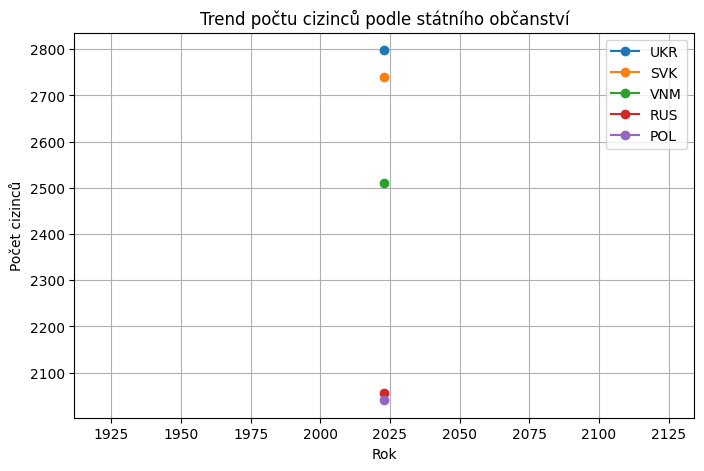

In [19]:
# 3) Jednoduchá vizualizace: trend počtu cizinců pro vybrané státy
top5 = grouped_foreigners.groupby('country')['foreigners_count'] \
                        .sum() \
                        .nlargest(5) \
                        .index.tolist()
plt.figure(figsize=(8,5))
for c in top5:
    sub = grouped_foreigners[grouped_foreigners['country']==c]
    plt.plot(sub['year'], sub['foreigners_count'], marker='o', label=c)
plt.title("Trend počtu cizinců podle státního občanství")
plt.xlabel("Rok")
plt.ylabel("Počet cizinců")
plt.legend()
plt.grid(True)
plt.show()

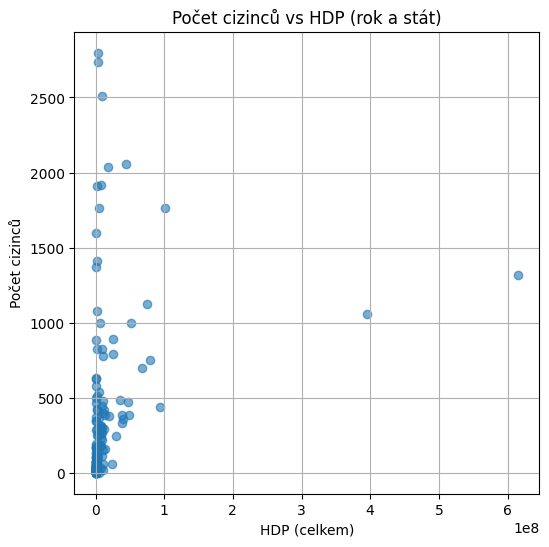

In [20]:
# 4) Scatter plot: cizinci vs HDP
plt.figure(figsize=(6,6))
plt.scatter(merged['GDP'], merged['foreigners_count'], alpha=0.6)
plt.title("Počet cizinců vs HDP (rok a stát)")
plt.xlabel("HDP (celkem)")
plt.ylabel("Počet cizinců")
plt.grid(True)
plt.show()

# Návrh struktury datového skladu

Dimenzionální model (hvězdicové schéma):

Dimenze:
- **DimDate**: id, year  
- **DimCountry**: id, iso_code, country_name  
- **DimAgeGroup**: id, age_group  

Faktové tabulky:
- **FactForeigners**: id, date_id, country_id, age_group_id, foreigners_count  
- **FactGDP**: id, date_id, country_id, gdp  

Schéma:
```